In [1]:
%matplotlib inline

In [2]:
from modelclass import model 
import modelmf
model.widescreen()
model.scroll_off()

In [3]:
import modelmf

from modelinvert import targets_instruments
from modelclass import model


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
mpak,baseline = model.modelload('../../models/pak.pcim',alfa=0.7,run=1,ljit=0)

In [6]:
for variable in ['PAKGGREVCO2CER', 'PAKGGREVCO2GER', 'PAKGGREVCO2OER']:
    print(variable,':',mpak.var_description[variable])
    

PAKGGREVCO2CER : Tax/subsidy (Coal) (USD p/tco2)
PAKGGREVCO2GER : Tax/subsidy (Gas) (USD p/tco2)
PAKGGREVCO2OER : Tax/subsidy (Oil) (USD p/tco2)


In [7]:
extra_description = {'PAKNYGDPMKTPKN': 'GDP',
 'PAKNECONPRVTKN': 'Consumption',
 'PAKNEGDIFTOTKN': 'Investment',
 'PAKNEEXPGNFSKN': 'Exports',
 'PAKNEIMPGNFSKN': 'Import',
 'PAKLMUNRTOTLCN': 'Unemployment rate',
 'PAKGGDBTTOTLCN_': 'Debt (%GDP)',
 'PAKCCEMISCO2TKN': 'Total emissions from fossil fuels',
 'PAKCCEMISCO2CKN': 'Emissions from Coal',
 'PAKCCEMISCO2OKN': 'Emissions from Oil',
 'PAKCCEMISCO2GKN': 'Emissions from Natural Gas',
 'PAKGGREVTOTLCN': 'Fiscal revenues',
 'PAKWDL': 'Working days lost due to pollution'}
mpak.set_var_description({**mpak.var_description,**extra_description})

In [8]:
target_var = ['PAKCCEMISCO2TKN']
instruments = [['PAKGGREVCO2CER','PAKGGREVCO2GER', 'PAKGGREVCO2OER']]
reduction_percent = 30
target_value = mpak.basedf.loc[2100,target_var[0]]*(1-reduction_percent/100)

In [9]:
bau_2022 = baseline.loc[2022,'PAKCCEMISCO2TKN']
target_growthrate = (target_value/bau_2022)**(1/(2100-2022))

In [10]:
target_before = baseline.loc[2022:,['PAKCCEMISCO2TKN']]     # Create dataframe with only the target variable 
# create a target dataframe with a projection of the target variable 
target = target_before.mfcalc(f'PAKCCEMISCO2TKN = PAKCCEMISCO2TKN(-1) * {target_growthrate}',2023,2100 )

In [11]:
_ = mpak.invert(mpak.basedf,targets = target,
                            instruments=instruments,
                          DefaultImpuls=2,defaultconv=2.0,varimpulse=True,nonlin=15,silent=1)

Finding instruments :   0%|          | 0/79

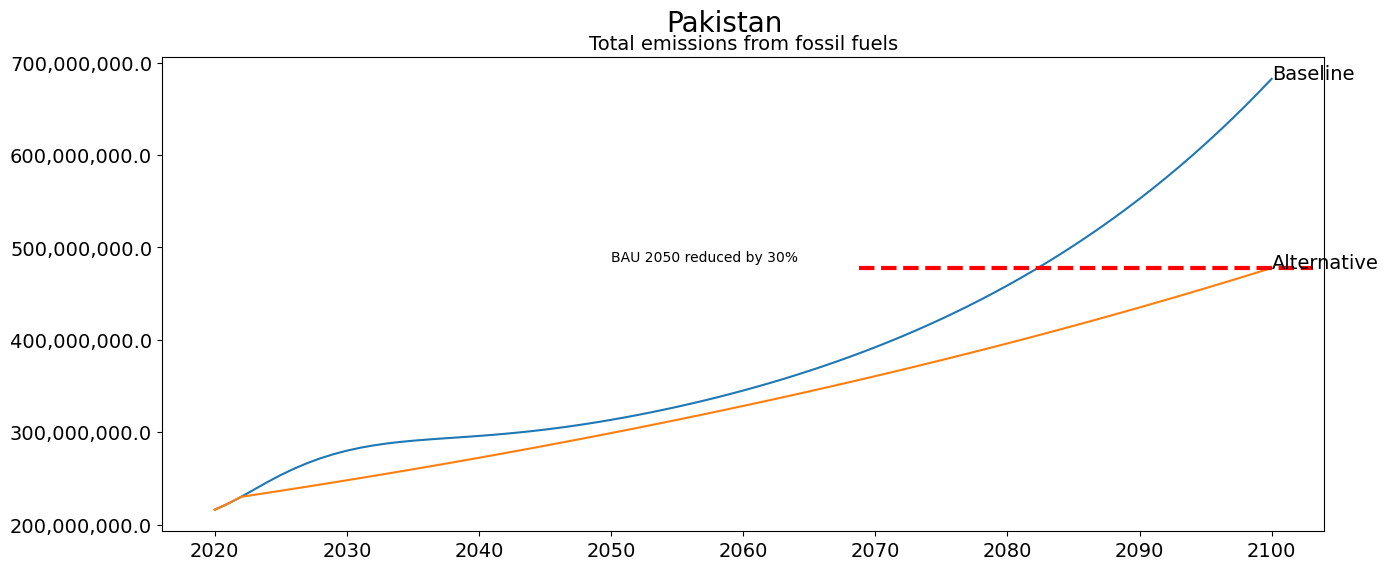

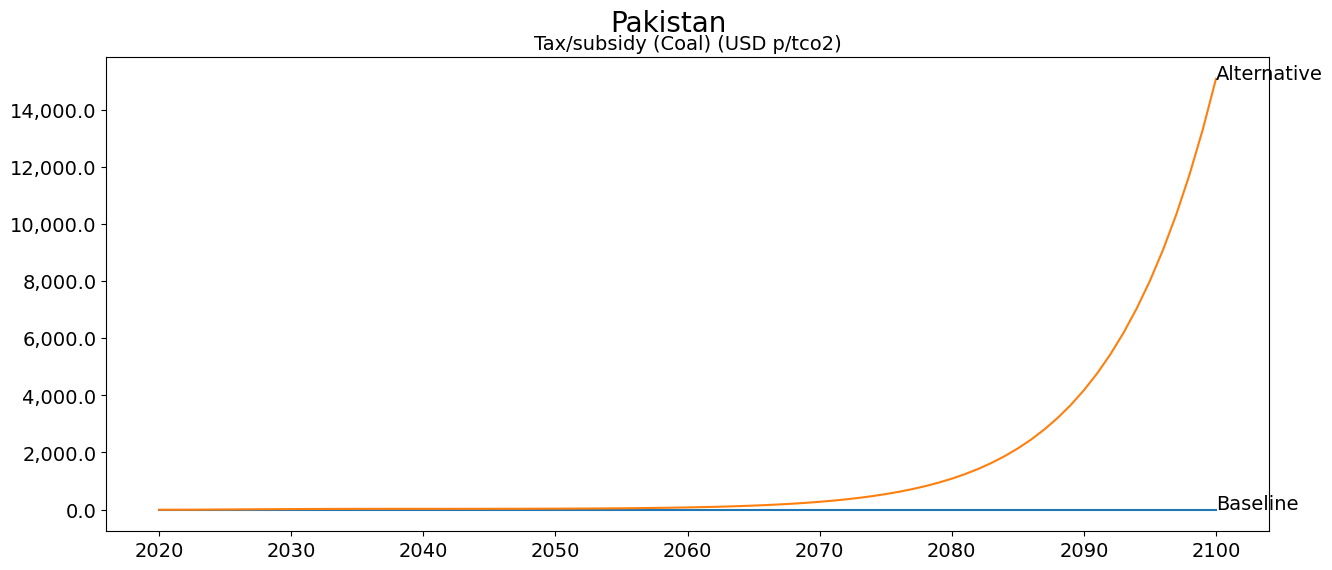

In [12]:
with mpak.set_smpl(2020,2100):    # change if you want another  timeframe 
    fig = mpak[f'PAKCCEMISCO2TKN' ].plot_alt(title='Pakistan')
    fig.axes[0].axhline( target_value,
                                  xmin=0.6,
                                  xmax = 0.99,
                                  linewidth=3, 
                                  color='r', ls='dashed')

    fig.axes[0].annotate(f'BAU 2050 reduced by {reduction_percent}%', xy=(2050,target_value*1.015 ))
    fig2 = mpak[f'PAKGGREVCO2CER' ].plot_alt(title=f'Pakistan'); 


In [13]:
mpak['PAKNYGDPMKTPKN PAKNECONGOVTKN PAKNEGDIFTOTKN PAKNEIMPGNFSKN PAKCCEMISCO2TKN']

In [14]:
new_instruments =[[('PAKGGREVCO2CER',10),
                   ('PAKGGREVCO2GER', 5),
                   ('PAKGGREVCO2OER',5)]]


_ = mpak.invert(mpak.basedf,targets = target,
                            instruments=new_instruments,
                          DefaultImpuls=1,
                                defaultconv=2.0,varimpulse=True,nonlin=15,silent=1)

Finding instruments :   0%|          | 0/79

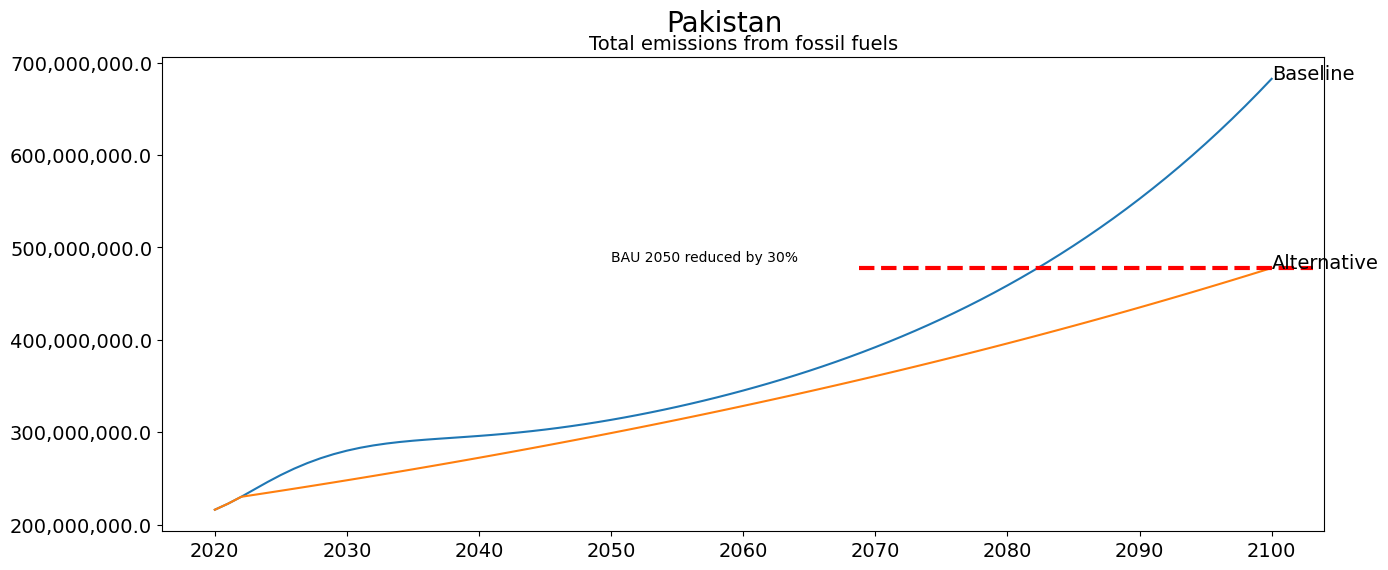

In [15]:
with mpak.set_smpl(2020,2100):    # change if you want another  timeframe 
    fig = mpak[f'PAKCCEMISCO2TKN' ].plot_alt(title='Pakistan')
    fig.axes[0].axhline( target_value,
                                  xmin=0.6,
                                  xmax = 0.99,
                                  linewidth=3, 
                                  color='r', ls='dashed')

    fig.axes[0].annotate(f'BAU 2050 reduced by {reduction_percent}%', xy=(2050,target_value*1.015 ))

In [16]:
    mpak['PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER' ]

In [17]:
help(mpak.invert)

Help on method invert in module modelclass:

invert(databank, targets, instruments, silent=1, DefaultImpuls=0.01, defaultconv=0.001, nonlin=False, maxiter=30, **kwargs) method of modelclass.model instance
    Solves instruments for targets



In [18]:
import modelinvert
help(modelinvert.targets_instruments)

Help on class targets_instruments in module modelinvert:

class targets_instruments(builtins.object)
 |  targets_instruments(databank, targets, instruments, model, DefaultImpuls=0.01, defaultconv=0.01, nonlin=False, silent=True, maxiter=30, solveopt={}, varimpulse=False)
 |  
 |  Class to handle general target/instrument problems. 
 |  Where the response is delayed specify this with delay.
 |  
 |  Number of targets should be equal to number of instruments 
 |  
 |  An instrument can comprice of severeral variables
 |  
 |  **Instruments** are inputtet as a list of instruments
 |  
 |  To calculate the jacobian each instrument variable has a impuls, 
 |  which is used as delta when evaluating the jacobi matrix:: 
 |      
 |    [ 'QO_J','TG']   Simple list each variable are shocked by the default impulse 
 |    [ ('QO_J',0.5), 'TG']  Here QO_J is getting its own impuls (0.5)
 |    [ [('QO_J',0.5),('ORLOV',1.)] , ('TG',0.01)] here an impuls is given for each variable, and the first inst